# General instructions for all labs

1. To turn in:
 - this python notebook, filled out (2 pts)
 - a *standalone* PDF report that contains all the plots, and the answers to all the discussion questions (2 pts)

2. Use of ChatGPT / CoPilot / etc:
   - Allowed, but you own everything that is generated
   - This means that any part of the solution can be asked in the quiz. It can be as detailed as "What was the batch size you used in training" or specific as "what exactly does masking do in this case?" Any discussion question is also game for a quiz question.
   - If I find AI usage to be excessive. I can individually drag any of you in for a 1-1 meeting, in which I grill you on your code. If it looks like irresponsible copy/pasting, without proper understanding, I reserve the right to drastically lower your grade, or even submit cases to GGAC for ethical review.
  
3. Use of peer collaboration:
   - In general not allowed. (Discussion / comparing answers is ok, but work on actual coding independently.)
   - Exceptions can be made if you all wrote your own training script, but 1. it takes forever to train or 2. you don't have great compute resources. Then you can share a trained model amongst yourself *and declare it on your pdf*. However, the code for training *still must be written by yourself*
     


## **Lab 1 Overview**

This lab explores how domain-specific training shapes NanoGPT’s internal representations and output behavior. You will train three separate *small* NanoGPT models on distinct, **tiny** corpora (each \~50–200 KB of text):

1. **Shakespeare corpus** – Short subset of public-domain plays.
2. **Wikipedia corpus** – Small scraped/cleaned sample from open Wikipedia dumps.
3. **Math textbook corpus** – Small public-domain math primer or textbook excerpt.

By comparing these models across zero-shot and few-shot settings, you will observe how the same generative architecture adapts its “classification” over the vocabulary depending on the training distribution.


## **Learning Outcomes**

By the end of the lab, students should:

1. Recognize that **generation is token-level classification**, and that domain-specific data shifts the learned classification boundaries.
2. Understand **zero-shot vs. few-shot** generalization in the context of specialized generative models.
3. Interpret **softmax confidence** and detect overconfidence/oversaturation phenomena.
4. Apply **model interpretability tools** (Grad-CAM) to compare how domain training changes token importance.
5. Connect all observations to **overfitting, evaluation metrics, and embeddings**.


## **Part 1 – Training Domain-Specific Models**

* Use the **same small NanoGPT config** (e.g., `n_layer=2`, `n_head=2`, `n_embd=128`, `block_size=64`) for all runs.
* Train on CPU or free Colab GPU — each model should converge in minutes given the small corpora and reduced parameters.
* Monitor:

  * Training loss curves.
  * Qualitative performance of generated samples.

This section mostly requires you to run scripts that are already written. At each step, pay close attention to the comments, as you may be asked about them in the future.

In [ ]:
import os, io, zipfile, requests
from pathlib import Path

# Choose the corpus
corpus_name = "math"  # Change to "shakespeare", "wikipedia", or "math"

# Reliable sources:
# - shakespeare: Karpathy's tiny Shakespeare (plain text)
# - wikipedia: https://www.kaggle.com/datasets/ffatty/plain-text-wikipedia-simpleenglish
# - math: https://archive.org/stream/CalculusMadeEasy/Calculus_Made_Easy_Thompson_djvu.txt



# Download and show sample


text = Path(f"data/{corpus_name}.txt").read_text(encoding="utf-8", errors="ignore")
print(f"Corpus: {corpus_name}; Corpus length: {len(text)} characters")
print("Sample:")
print(text[:300])
print("...")




Corpus: math; Corpus length: 284987 characters
Sample:
/ /v >0 erf J <TT 

r 
/as QAfeJtedAf. 



CALCULUS MADE EASY 



J&cftfe 



THE MACMILLAN COMPANY 

NEW YORK • BOSTON . CHICAGO • DALLAS 
ATLANTA . SAN FRANCISCO 

MACMILLAN AND CO., Limited 

LONDON . BOMBAY . CALCUTTA . MADRAS 
MELBOURNE 

THE MACMILLAN COMPANY 
OF CANADA, Limited 

TORONTO 




...


In [ ]:
# -----------------------------------------
# Prepare dataset for character-level modeling
# -----------------------------------------

import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torch.utils.data import DataLoader

class CharDataset(Dataset):
    def __init__(self, text, block_size, stoi=None, itos=None):
        """
        text: The raw text string we want to train on.
        block_size: The length of each training sequence (number of characters).
        stoi, itos: Optional vocab mappings. If provided, reuse them.
        """

        self.text=text
        # 1. Build or reuse the vocabulary
        if stoi is None or itos is None:
            # Build from scratch
            self.chars = sorted(list(set(text)))
            self.vocab_size = len(self.chars)
            self.stoi = {ch: i for i, ch in enumerate(self.chars)}
            self.itos = {i: ch for i, ch in enumerate(self.chars)}
        else:
            # Reuse given vocab
            self.stoi = stoi
            self.itos = itos
            self.vocab_size = len(self.stoi)

        # 2. Store sequence length
        self.block_size = block_size

        # 3. Encode dataset into indices
        #    Use .get(ch, 0) so unknown characters map to 0
        self.data = torch.tensor([self.stoi.get(c, 0) for c in text], dtype=torch.long)

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx : idx + self.block_size + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y


block_size = 64

text = Path(f"data/math.txt").read_text(encoding="utf-8", errors="ignore")
dataset = CharDataset(text, block_size=block_size, stoi=None, itos=None)





## Analysis: Character Frequency Histogram

Visualize the differences in vocabulary and character usage between corpora (`shakespeare`, `wikipedia`, `math`). Do this by creating a histogram of each character's frequency of occurance, for each corpora.
  
Unicode safety

   * Some characters may not render properly in plots or Jupyter.
   * Replace problematic characters with their Unicode code point.
   * Example helper function:

     ```python
     def safe_label(c):
         try:
             c.encode("ascii")  # check if ASCII-printable
             return c
         except UnicodeEncodeError:
             return f"U+{ord(c):04X}"
     ```


   * Generate one histogram for each corpus (`shakespeare`, `wikipedia`, `math`).
   * For each corpus, write **1–2 sentences** describing:

     * Which characters are most common.
     * Any unusual symbols or formatting.
     * How the distributation of the corpus represents a distribution of a more general language model, e.g. one learned by ChatGPT.



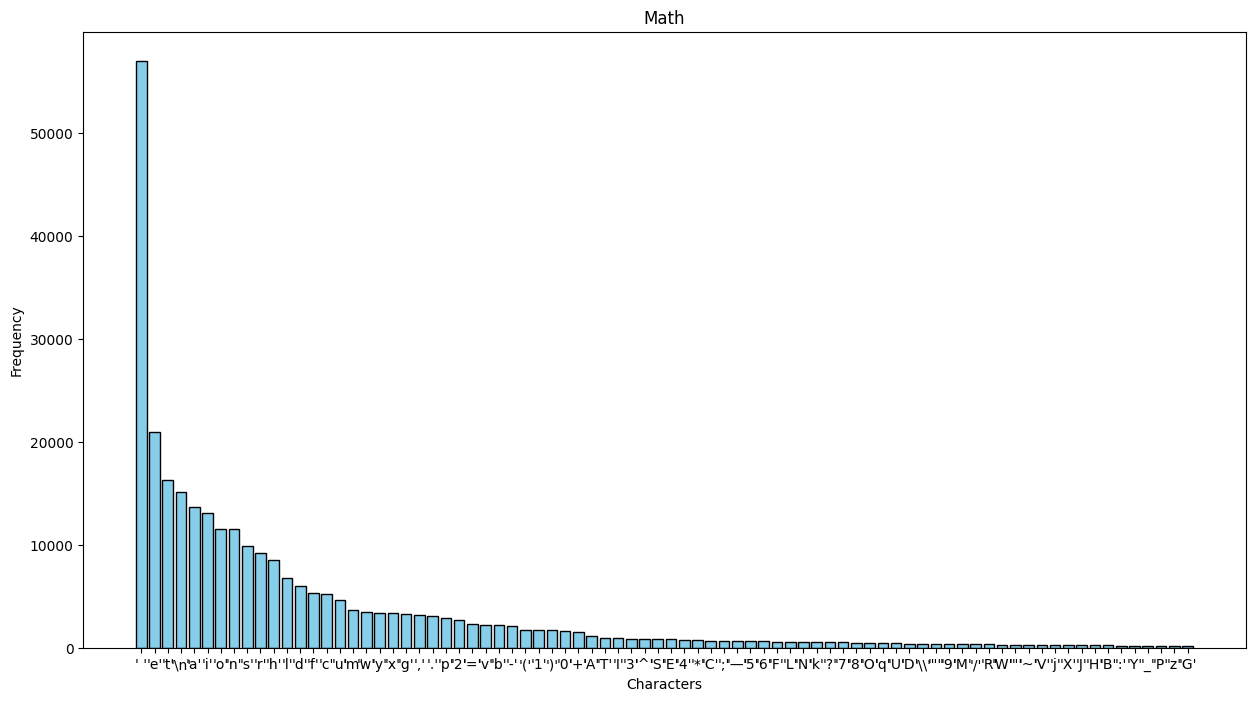

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
plt.rcParams["font.family"] = "DejaVu Sans"

unique_text = dataset.chars
text_size = dataset.vocab_size
counts = Counter(text)
top_80 = counts.most_common(80)
labels, values = zip(*top_80)
labels = [repr(label) for label in labels]
plt.figure(figsize=(15, 8))
plt.bar(labels, values, color="skyblue", edgecolor="black")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.title("Math")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append("/content/drive/MyDrive/")

Mounted at /content/drive


In [ ]:
from nanogpt_model import GPT  # Import the GPT model class from the NanoGPT repo


# -----------------------------------------
# Define a configuration object for the GPT model
# -----------------------------------------
class GPTConfig:
    def __init__(self, vocab_size, block_size,
                 n_layer=2, n_head=2, n_embd=128, dropout=0.0, bias = True):
        """
        This class is a container for all the key hyperparameters
        that define the size and shape of the GPT model.
        We pass this config into the GPT constructor so the model
        can be built with these exact settings.

        ---------------------------
        Parameter meanings:
        ---------------------------

        vocab_size:
            - Number of unique tokens in our dataset.
            - In a character-level model, this is the number of distinct characters.
            - Maps directly to the size of the token embedding matrix:
                token_embedding_table.shape == (vocab_size, n_embd)

        block_size:
            - Maximum context length (sequence length) the model sees at once.
            - Sets the width of the positional embedding table:
                position_embedding_table.shape == (block_size, n_embd)
            - Also defines the mask size in self-attention so the model only attends
              to the last `block_size` tokens.

        n_layer:
            - Number of Transformer blocks stacked in the model.
            - Each block = (Multi-Head Self-Attention + Feedforward MLP + LayerNorm).
            - More layers allow the model to capture more complex dependencies.

        n_head:
            - Number of attention heads per multi-head attention layer.
            - Each head learns to focus on different positions/tokens in the sequence.
            - Heads are concatenated then projected back into `n_embd` dimensions.

        n_embd:
            - Dimensionality of token embeddings and all hidden states.
            - Controls the "width" of the model.
            - Affects:
                * Token embedding size
                * Positional embedding size
                * Per-head dimension in attention: head_dim = n_embd / n_head
                * Hidden size of the feedforward layers in each block.

        dropout:
            - Dropout probability applied in various places (attention, MLP) during training.
            - Helps prevent overfitting by randomly zeroing activations.

        """

        # Store all parameters for use by the GPT class
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout
        self.bias = bias


config = GPTConfig(vocab_size=dataset.vocab_size, block_size=block_size)
model = GPT(config)
print(model)



number of parameters: 0.41M
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(110, 128)
    (wpe): Embedding(64, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=True)
          (c_proj): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=110, bias=False)
)




## Analysis: Model Architecture Diagram

Create a clear, labeled diagram of the NanoGPT model you trained, showing the **flow of data** from input to output, including the **shapes/dimensions** at each stage. Do this *by hand*. You may use a tablet, but it cannot look code-generated.


1. **Overall Layout**

   * Show the full pipeline:
     **Input Tokens → Token Embedding → Positional Embedding → Transformer Blocks → LayerNorm → Output Head → Softmax**.

2. **Transformer Blocks**

   * Each block should include:

     * **LayerNorm 1 → Multi-Head Causal Self-Attention → Residual Connection**
     * **LayerNorm 2 → Feedforward MLP → Residual Connection**
   * Clearly label these sub-components and indicate that this block repeats `n_layer` times.

3. **Dimensions**

   * Label the **shape** of the tensor at each stage (batch size = `B`, sequence length = `T`, embedding size = `n_embd`):

     * Input: `(B, T)` (integer token IDs)
     * Token embeddings: `(B, T, n_embd)`
     * After adding positional embeddings: `(B, T, n_embd)`
     * Inside attention: queries/keys/values → `(B, n_head, T, head_dim)`
     * MLP layers: `(B, T, 4*n_embd)` then back to `(B, T, n_embd)`
     * Output logits: `(B, T, vocab_size)`

4. **Connections**

   * Draw arrows between each component to show the data flow.
   * Mark residual connections that add the block’s input to its output.

5. **Label Hyperparameters**

   * Include:

     * `n_layer` = number of transformer blocks
     * `n_head` = number of attention heads per block
     * `n_embd` = embedding dimension
     * `block_size` = maximum context length
     * `vocab_size` = size of the token vocabulary

6. **Final Output**

   * Show that the model outputs logits for each token position, then a softmax over the vocabulary to get probabilities.




In [ ]:
import torch
import torch.nn.functional as F

def inspect_model_flow(model, prompt, stoi, max_len=20):
    """
    Inspect the flow of tensors inside GPT model for a given prompt.
    Prints out shapes for each stage.
    """
    # Encode prompt into tensor
    x = torch.tensor([stoi.get(c, 0) for c in prompt], dtype=torch.long)[None, :]  # [B, T]
    print(f"\n=== Inspecting prompt: {repr(prompt)} ===")
    print(f"Input tokens shape: {x.shape}")

    hooks = []

    def make_hook(name):
        def hook(module, inp, out):
            if isinstance(out, torch.Tensor):
                print(f"{name}: {tuple(out.shape)}")
            elif isinstance(out, (list, tuple)):
                shapes = [tuple(o.shape) for o in out if isinstance(o, torch.Tensor)]
                print(f"{name}: {shapes}")
            else:
                print(f"{name}: {type(out)}")
        return hook

    # Register hooks
    hooks.append(model.transformer.wte.register_forward_hook(make_hook("Token Embedding")))
    hooks.append(model.transformer.wpe.register_forward_hook(make_hook("Positional Embedding")))
    for i, block in enumerate(model.transformer.h):
        hooks.append(block.register_forward_hook(make_hook(f"Transformer Block {i}")))
    hooks.append(model.transformer.ln_f.register_forward_hook(make_hook("LayerNorm")))
    hooks.append(model.lm_head.register_forward_hook(make_hook("Output Head")))

    # Forward pass
    with torch.no_grad():
        logits, _ = model(x)

    print("Softmax:", tuple(F.softmax(logits, dim=-1).shape))

    # Remove hooks
    for h in hooks:
        h.remove()


In [ ]:
ckpt = torch.load("drive/MyDrive/checkpoints/math/iter_5000.pt", map_location="cpu")
stoi, itos = ckpt["stoi"], ckpt["itos"]
vocab_size = len(stoi)

config = GPTConfig(vocab_size=vocab_size,block_size=64)
model = GPT(config)
model.load_state_dict(ckpt["model_state"])
model.eval()

inspect_model_flow(model, "hello", stoi)


number of parameters: 0.41M

=== Inspecting prompt: 'hello' ===
Input tokens shape: torch.Size([1, 5])
Token Embedding: (1, 5, 128)
Positional Embedding: (5, 128)
Transformer Block 0: (1, 5, 128)
Transformer Block 1: (1, 5, 128)
LayerNorm: (1, 5, 128)
Output Head: (1, 1, 110)
Softmax: (1, 1, 110)


In [ ]:
ckpt = torch.load("drive/MyDrive/checkpoints/wikipedia/iter_5000.pt", map_location="cpu")
stoi, itos = ckpt["stoi"], ckpt["itos"]
vocab_size = len(stoi)

config = GPTConfig(vocab_size=vocab_size,block_size=64)
model = GPT(config)
model.load_state_dict(ckpt["model_state"])
model.eval()

inspect_model_flow(model, "hello", stoi)

number of parameters: 0.43M

=== Inspecting prompt: 'hello' ===
Input tokens shape: torch.Size([1, 5])
Token Embedding: (1, 5, 128)
Positional Embedding: (5, 128)
Transformer Block 0: (1, 5, 128)
Transformer Block 1: (1, 5, 128)
LayerNorm: (1, 5, 128)
Output Head: (1, 1, 292)
Softmax: (1, 1, 292)


In [ ]:
ckpt = torch.load("drive/MyDrive/checkpoints/shakespeare/iter_5000.pt", map_location="cpu")
stoi, itos = ckpt["stoi"], ckpt["itos"]
vocab_size = len(stoi)

config = GPTConfig(vocab_size=vocab_size,block_size=64)
model = GPT(config)
model.load_state_dict(ckpt["model_state"])
model.eval()

inspect_model_flow(model, "hello", stoi)

number of parameters: 0.41M

=== Inspecting prompt: 'hello' ===
Input tokens shape: torch.Size([1, 5])
Token Embedding: (1, 5, 128)
Positional Embedding: (5, 128)
Transformer Block 0: (1, 5, 128)
Transformer Block 1: (1, 5, 128)
LayerNorm: (1, 5, 128)
Output Head: (1, 1, 65)
Softmax: (1, 1, 65)




## Training NanoGPT

The following code actually **trains NanoGPT** on your selected dataset.
Your job is to:

1. **Play around with the hyperparameters** (e.g. learning rate, batch size, context length, number of layers).
2. **Run the training loop** long enough to get meaningful results.
3. **Save a trained checkpoint for each of the three corpora** (`shakespeare`, `wikipedia`, `math`).

After training:

* You should have a folder of checkpoints (e.g. `checkpoints/shakespeare/final.pt`).
* Each corpus will give you a slightly different “voice” when you generate text.


In [ ]:
import os
import torch
from tqdm import tqdm
# Directory for this corpus
corpus_name = "math" # "math", "shakespeare", "wikipedia"
ckpt_dir = os.path.join("checkpoints", corpus_name)
os.makedirs(ckpt_dir, exist_ok=True)
final_ckpt_path = os.path.join(ckpt_dir, "final.pt")

if os.path.exists(final_ckpt_path):
    print(f"Final checkpoint for '{corpus_name}' found at {final_ckpt_path}.")
    ckpt = torch.load(final_ckpt_path, map_location="cpu")
    model.load_state_dict(ckpt["model_state"])
    losses = ckpt.get("losses", [])
    print(f"Loaded model with {len(losses)} stored loss values.")
else:
    print(f"No checkpoint found for '{corpus_name}', starting training...")
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    max_iters = 5000

    losses = []   # will now store only full-batch eval losses
    model.train()
    for it in range(max_iters):
        xb, yb = next(iter(loader))

        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if it % 100 == 0:
            # Evaluate on full dataset (avg loss across all batches)
            model.eval()
            eval_losses = []

            max_batches = len(loader) * 0.01
            for i, (xb_eval, yb_eval) in enumerate(loader):
                if i >= max_batches:  break
                logits_eval, loss_eval = model(xb_eval, yb_eval)
                eval_losses.append(loss_eval.item())
            avg_loss = torch.mean(torch.tensor(eval_losses))
            losses.append(avg_loss)
            print(f"Iter {it}/{max_iters}, Avg Loss over dataset: {avg_loss:.4f}")

            # Save periodic checkpoint
            iter_ckpt_path = os.path.join(ckpt_dir, f"iter_{it}.pt")
            torch.save({
                "model_state": model.state_dict(),
                "config": config.__dict__,
                "itos": dataset.itos,
                "stoi": dataset.stoi,
                "losses": losses
            }, iter_ckpt_path)
            print(f"Saved checkpoint: {iter_ckpt_path}")
            model.train()  # back to training mode

    # Save final checkpoint
    torch.save({
        "model_state": model.state_dict(),
        "config": config.__dict__,
        "itos": dataset.itos,
        "stoi": dataset.stoi,
        "losses": losses
    }, final_ckpt_path)
    print(f"Saved final model to {final_ckpt_path}")


No checkpoint found for 'math', starting training...
Iter 0/5000, Avg Loss over dataset: 4.2223
Saved checkpoint: checkpoints/math/iter_0.pt
Iter 100/5000, Avg Loss over dataset: 2.6013
Saved checkpoint: checkpoints/math/iter_100.pt
Iter 200/5000, Avg Loss over dataset: 2.4111
Saved checkpoint: checkpoints/math/iter_200.pt
Iter 300/5000, Avg Loss over dataset: 2.2535
Saved checkpoint: checkpoints/math/iter_300.pt
Iter 400/5000, Avg Loss over dataset: 2.1061
Saved checkpoint: checkpoints/math/iter_400.pt
Iter 500/5000, Avg Loss over dataset: 1.9912
Saved checkpoint: checkpoints/math/iter_500.pt
Iter 600/5000, Avg Loss over dataset: 1.9108
Saved checkpoint: checkpoints/math/iter_600.pt
Iter 700/5000, Avg Loss over dataset: 1.8426
Saved checkpoint: checkpoints/math/iter_700.pt
Iter 800/5000, Avg Loss over dataset: 1.7977
Saved checkpoint: checkpoints/math/iter_800.pt
Iter 900/5000, Avg Loss over dataset: 1.7658
Saved checkpoint: checkpoints/math/iter_900.pt
Iter 1000/5000, Avg Loss over d

In [ ]:
!zip -r checkpoints.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/math/ (stored 0%)
  adding: checkpoints/math/iter_500.pt (deflated 8%)
  adding: checkpoints/math/iter_3900.pt (deflated 8%)
  adding: checkpoints/math/iter_3500.pt (deflated 8%)
  adding: checkpoints/math/iter_4600.pt (deflated 8%)
  adding: checkpoints/math/iter_2300.pt (deflated 8%)
  adding: checkpoints/math/iter_2200.pt (deflated 8%)
  adding: checkpoints/math/iter_800.pt (deflated 8%)
  adding: checkpoints/math/iter_3100.pt (deflated 8%)
  adding: checkpoints/math/iter_900.pt (deflated 8%)
  adding: checkpoints/math/iter_4700.pt (deflated 8%)
  adding: checkpoints/math/iter_1200.pt (deflated 8%)
  adding: checkpoints/math/iter_2000.pt (deflated 8%)
  adding: checkpoints/math/iter_400.pt (deflated 8%)
  adding: checkpoints/math/iter_2600.pt (deflated 8%)
  adding: checkpoints/math/final.pt (deflated 8%)
  adding: checkpoints/math/iter_3300.pt (deflated 8%)
  adding: checkpoints/math/iter_0.pt (deflated 8%)
  adding: checkpoi

## Analysis: Track Model Output Over Training


### **Procedure**
* Extract model checkpoints every **100 iterations** (e.g., `iter_100.pt`, `iter_200.pt`, `iter_300.pt`, …).
* For each corpus (`shakespeare`, `wikipedia`, `math`):
 * Use the provided generation code to produce **one line of generated text** from the **same fixed prompt** (e.g., `"Once upon a time"`).
 * If you find the output has not yet achieved the langauge structure quality you desire, you may want to train it for longer. Go until you have a strong model.

---

### **Consistency**

* Keep the **prompt** identical across all checkpoints, but consistent to the corpora in mind.
* Use the same **number of generated tokens** each time.
* This ensures you can make direct comparisons between outputs.

---

### **Reporting**

In your lab report:

* Include a short **table or list** for each corpus showing:

  * Iteration number.
  * The generated output (first \~100 characters).

* Discuss the following:

  * At what point does the text start to look coherent?
  * How does the style differ between Shakespeare, Wikipedia, and Math?
  * Does the model become **overconfident** (repetitive text, fixed patterns) at later stages?

In [ ]:
import os

# This code loads a specific training checkpoint of NanoGPT
# (saved during training) and uses it to generate text.


def generate_small_text(corpus, start_text, iteration_to_load, max_new_tokens):
    # Path to the specific checkpoint

    if iteration_to_load == "final":
        ckpt_path = os.path.join("checkpoints", corpus, "final.pt")
    else:
        ckpt_path = os.path.join("checkpoints", corpus, f"iter_{iteration_to_load}.pt")

    if not os.path.exists(ckpt_path):
        print(f"Checkpoint {ckpt_path} not found. Make sure to train first.")
    else:
        # Load checkpoint from disk
        ckpt = torch.load(ckpt_path, map_location="cpu")

        # Rebuild the GPT model from saved config
        loaded_config = type("GPTConfig", (), ckpt["config"])
        gen_model = GPT(loaded_config)
        gen_model.load_state_dict(ckpt["model_state"])
        gen_model.eval()

        # Tokenization: convert characters to IDs
        stoi = ckpt["stoi"]
        itos = ckpt["itos"]
        idx = torch.tensor([stoi.get(c, 0) for c in start_text], dtype=torch.long).unsqueeze(0)

        # Autoregressive generation loop
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Feed only the last block_size tokens
                idx_cond = idx[:, -loaded_config.block_size:]
                logits, _ = gen_model(idx_cond)

                # Convert logits to probabilities
                probs = torch.softmax(logits[:, -1, :], dim=-1)

                # Sample next token from probability distribution
                idx_next = torch.multinomial(probs, num_samples=1)

                # Append new token to the sequence
                idx = torch.cat((idx, idx_next), dim=1)

        # Decode IDs back into text
        generated_text = ''.join([itos[i.item()] for i in idx[0]])
        return generated_text

In [ ]:
import pandas as pd

# Initialize an empty list to store results
results = []

# Loop from 100 to 5000 (inclusive), step size = 100

for i in range(0, 4901, 100):
    # Store (iteration, string) as a tuple
    s = generate_small_text("math", "Once upon a time", f"{i}", 100)
    results.append((i,s))

s = generate_small_text("math", "Once upon a time", "final", 100)
results.append(("final",s))

# Convert list of tuples into a DataFrame (table)
df = pd.DataFrame(results, columns=["Iteration", "String"])

# Show the table
print(df)

# Optionally, save to CSV
df.to_csv("iteration_strings_math.csv", index=False)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters

In [ ]:
# Initialize an empty list to store results
results = []

# Loop from 100 to 5000 (inclusive), step size = 100

for i in range(5):
    # Store (iteration, string) as a tuple
    s = generate_small_text("math", "Once upon a time","final", 100)
    results.append((i,s))

# Convert list of tuples into a DataFrame (table)
df = pd.DataFrame(results, columns=["Iteration", "String"])

# Show the table
print(df)

# Optionally, save to CSV
df.to_csv("iteration_strings_final_math.csv", index=False)

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
   Iteration                                             String
0          0  Once upon a timension, preded \n\nThe process ...
1          1  Once upon a time hourselves, however, 4000 \n\...
2          2  Once upon a time, this \nof the capacite will ...
3          3  Once upon a time, that is the arc \nfirst nown...
4          4  Once upon a time of C alcoes, as \nits such ei...


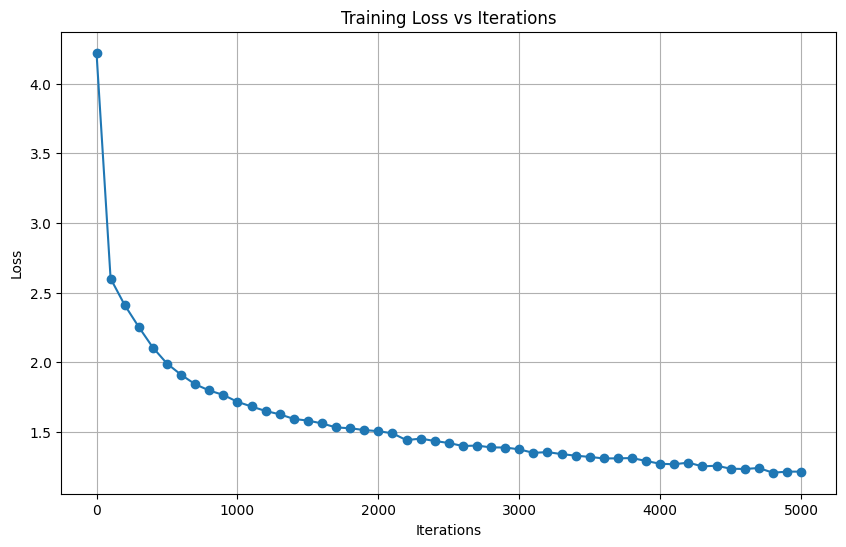

In [ ]:
import torch
import glob
import re
import matplotlib.pyplot as plt

# Find all checkpoint files matching iter_*.pt
files = glob.glob("checkpoints/math/iter_*.pt")

iterations = []
loss_values = []

for f in files:
    # Extract iteration number from filename using regex
    match = re.search(r"iter_(\d+)\.pt", f)
    if match:
        iteration = int(match.group(1))

        # Load checkpoint
        checkpoint = torch.load(f, map_location="cpu")

        # Extract losses (assuming it's a list or scalar)
        losses = checkpoint.get("losses", None)

        if losses is not None:
            # If it's a list, you might want the last value
            if isinstance(losses, (list, tuple)):
                loss_val = losses[-1]   # last loss
            else:
                loss_val = losses       # single value

            iterations.append(iteration)
            loss_values.append(loss_val)

# Sort by iteration (in case glob doesn't return in order)
iterations, loss_values = zip(*sorted(zip(iterations, loss_values)))

# Plot
plt.figure(figsize=(10,6))
plt.plot(iterations, loss_values, marker="o")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss vs Iterations")
plt.grid(True)
plt.show()

## Analysis: Variability of the Final Model

### **Procedure**

* After training, take the **final checkpoint** for each corpus.
* Using the same prompt as before (corpus-consistent), generate **multiple outputs (at least 5)**.
* Each output should use the same number of tokens, so they are directly comparable.

---

### **Consistency**

* Keep the prompt identical across all generations for each corpus.
* Do not change model parameters, only re-run generation.

---

### **Reporting**

In your lab report:

* Include the set of generated outputs from the final model.
* Comment on:

  * The **variance** across outputs: do they differ in interesting ways, or are they repetitive?
  * Whether the variability seems to capture the **style** of the corpus.
  * Whether you are satisfied with the outputs: does it feel like the model “learned” something meaningful?





## **Analysis: Plot Training Loss from Checkpoints**

* Produce **one loss curve plot per corpus** (`shakespeare`, `wikipedia`, `math`).
* Compare and contrast the training behavior across the different corpora.

**What to Comment On**

* Identify which loss values seem to correspond to **qualitatively good performance** (e.g., when the model starts producing coherent, domain-appropriate text).
* Note that the **initial drop in loss** is often not enough: real quality emerges only once the model reaches **very low error**.
* Discuss differences across corpora:

  * Which corpus needed lower loss values before outputs became convincing?
  * Do some domains “sound good” ons for what to hand in)?


## **Part 2 – Cross-Domain Evaluation**

* Evaluate each trained model **on each other’s dataset**:

  * **Zero-shot**: Direct prompt without domain examples.
  * **Few-shot**: Include 1–3 in-domain examples in the prompt.
* Compare:

  * Loss in-domain vs. out-of-domain.
  * Quality and relevance of generated continuations.





# Detailed Instructions

### **Part 2 Step 1: Zero-shot Evaluation**

For each dataset pair (A, B) where A, B ∈ {`wikipedia`, `math`, `shakespeare`}:

1. Load the **final checkpoint** of the model trained on A.

   * When rebuilding the model, you must restore the **vocab size** from the checkpoint, e.g.

     ```python
     vocab_size = len(ckpt["stoi"])
     model = GPT(vocab_size=vocab_size)
     ```
   * This ensures the embedding and output layers match the original training.
2. Evaluate it on dataset B **without in-domain examples**. Do so on 1% of the training data, as it is very large.
3. Record the **loss values** in a 3×3 table (diagonal = in-domain).
4. For each pair, include one **generated sample** with these instructions?


In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
import random
import glob
import re
import matplotlib.pyplot as plt

# Assume you already have: GPT class defined

datasets = ["wikipedia", "math", "shakespeare"]
block_size = 64

loss_matrix = {}
samples = {}

for A in datasets:
    # --- Load checkpoint trained on dataset A ---
    ckpt_path = f"drive/MyDrive/checkpoints/{A}/final.pt"   # adjust path
    ckpt = torch.load(ckpt_path, map_location="cpu")

    vocab_size = len(ckpt["stoi"])
    model = GPT(GPTConfig(vocab_size=vocab_size, block_size=block_size))
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    for B in datasets:
        # --- Load dataset B into CharDataset ---
        text = Path(f"data/{B}.txt").read_text(encoding="utf-8", errors="ignore")
        dataset_B = CharDataset(text, block_size=block_size, stoi=ckpt["stoi"], itos=ckpt["itos"])

        # Use only 1% of training data
        n = len(dataset_B)
        one_percent = max(1, n // 100)
        subset_indices = random.sample(range(n), one_percent)
        subset = Subset(dataset_B, subset_indices)
        loader = DataLoader(subset, batch_size=32)

        # --- Evaluate loss ---
        total_loss = 0
        count = 0
        with torch.no_grad():
            for x, y in loader:
                logits, loss = model(x, y)
                total_loss += loss.item() * x.size(0)
                count += x.size(0)
        avg_loss = total_loss / count
        loss_matrix[(A, B)] = avg_loss

        # --- Generate one sample on dataset B ---
        prompt = text[:block_size]  # take first block_size chars as seed
        prompt_encoded = torch.tensor([ckpt["stoi"].get(c, 0) for c in prompt], dtype=torch.long).unsqueeze(0)
        generated = model.generate(prompt_encoded, max_new_tokens=100, temperature=0.8)[0].tolist()
        generated_text = "".join([ckpt["itos"].get(i, "?") for i in generated])

        samples[(A, B)] = generated_text

# --- Print loss table ---
print("Loss Table:\n")
print("\t" + "\t".join(datasets))
for A in datasets:
    row = [A]
    for B in datasets:
        row.append(f"{loss_matrix[(A,B)]:.3f}")
    print("\t".join(row))

# --- Show sample generations ---
print("\nSample Generations:")
for (A, B), text in samples.items():
    print(f"\nModel trained on {A}, evaluated on {B}:\n{text}\n")


number of parameters: 0.43M
number of parameters: 0.41M
number of parameters: 0.41M
Loss Table:

	wikipedia	math	shakespeare
wikipedia	1.424	2.618	2.472
math	2.719	1.219	3.520
shakespeare	2.369	3.988	1.407

Sample Generations:

Model trained on wikipedia, evaluated on wikipedia:
April

April (Apr.) is the fourth month of the year in the Julian some account region buildings to were for about 310 in a value to transpital atoms Christians gove


Model trained on wikipedia, evaluated on math:
/ /v >0 erf J <TT 

r 
/as QAfeJtedAf. 



CALCULUS MADE EASY 

Saria (will a country is preper a fastron. But it thribes believe reserte the rained many to loak th


Model trained on wikipedia, evaluated on shakespeare:
First Citizen:
Before we proceed any further, hear me speak.

Alsometimes in 1993 events are viewstmerist and became of relapted and the ancient atoms, schoolar tri


Model trained on math, evaluated on wikipedia:
April

April (Apr.) is the fourth month of the year in the Juliable 
no

### **Part 2 Step 2: Few-shot Evaluation**

1. **Start from a Pretrained Model (Dataset A).**

   * Choose a model that has already been trained on dataset **A** (e.g., `wikipedia`, `math`, `shakespeare`).
   * Load the **final checkpoint** for A:

     ```python
     ckpt_path = f"checkpoints/{A}/final.pt"
     ckpt = torch.load(ckpt_path, map_location="cpu")
     ```
   * Important: the vocabulary size used for training A may differ from the default.

     * Before building the model, set

       ```python
       config.vocab_size = len(ckpt["stoi"])
       model = GPT(config)
       ```
     * This ensures the embedding and output layer dimensions match the checkpoint.
   * Finally, load the weights:

     ```python
     model.load_state_dict(ckpt["model_state"])
     ```

2. **Fine-tune on Dataset B.**

   * Use the **same vocabulary (`stoi`, `itos`) from dataset A** to enco0de dataset B.
   * Train for **200 iterations** with AdamW (`lr=**10, 25, 50, 100, 2ns thereafter if you extend training.
   * Naming convention:

     ```
     {A}_start{N}_{B}_run{M}.pt
     ```

     where

     * **A** = source dataset (e.g. `wikipedia`)
     * **B** = target dataset (e.g. `math`)
     * **N** = starting iteration (e.g. `0` if from scratch, or `500` if resuming)
     * **M** = current fine-tuning iteration

3. **Evaluate and Track Loss.**

   * Every 50 steps, evaluate on a **1% subsample of dataset B** for speed.
   * Record the average evaluation loss.
   * Keep a running list of these evaluation losses to plot later.

4. **Plot Loss Curves.**

   * After training, plot **loss vs iteration** for each experiment.
   * Compare curves across different (A→B) fine-tuning runs.
   * This shows how quickly and effectively each pretrained model adapts to dataset B.

5. **Examples**

   * At each saved checkpoint (10, 25, 50, 100, 200), generate short text continuations from the model.
   * Use the same sampling routine (temperature-controlled decoding).
   * Collect and compare generations to see how quality improves over epochs



number of parameters: 0.41M


  0%|          | 0/200 [00:00<?, ?it/s]

Step 1: eval loss = 2.3374


  1%|          | 2/200 [00:27<37:26, 11.35s/it]  

Sample @ step 1:
The theorem statesman: this she love, you come, I thank you are loved;
I am art ell accompanied himselves to heaven wi



 24%|██▍       | 49/200 [00:33<00:23,  6.50it/s]

Step 50: eval loss = 1.9361


 26%|██▌       | 51/200 [01:00<14:02,  5.65s/it]

Sample @ step 50:
The theorem states and deserve a fortuned that words the compossitinged sends the enemy be well as the sister the brai



 50%|████▉     | 99/200 [01:07<00:12,  7.78it/s]

Step 100: eval loss = 1.8420


 50%|█████     | 101/200 [01:34<09:26,  5.72s/it]

Sample @ step 100:
The theorem states and it carled the mat-called falls and general if the gentured Grance. 
'Country, which live is doi



 74%|███████▍  | 149/200 [01:40<00:06,  7.66it/s]

Step 150: eval loss = 1.7852


 76%|███████▌  | 151/200 [02:07<04:40,  5.73s/it]

Sample @ step 150:
The theorem states are rice or genereting rims in such or more oreuple fora salined to a sorther in sabil.

Force wher



100%|█████████▉| 199/200 [02:14<00:00,  7.66it/s]

Step 200: eval loss = 1.7443


100%|██████████| 200/200 [02:41<00:00,  1.24it/s]

Sample @ step 200:
The theorem states and conject it
forse mean a ni
 proclorian to negly ascall it. At the soveraphes that the bagges th



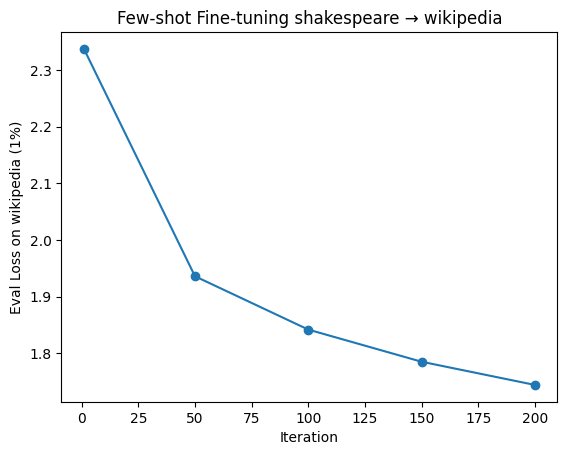

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from pathlib import Path
import random
import matplotlib.pyplot as plt
from tqdm import trange

# -------------------------
# Few-shot training & evaluation
# -------------------------
def few_shot_finetune(A, B, GPT, config, block_size=64, max_iters=200, batch_size=32, eval_interval=50):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1. Load pretrained checkpoint (dataset A)
    ckpt_path = f"drive/MyDrive/checkpoints/{A}/final.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")

    # 2. Build model with A’s vocab size
    config.vocab_size = len(ckpt["stoi"])
    model = GPT(config).to(device)
    model.load_state_dict(ckpt["model_state"])
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    # 3. Load dataset B, reusing A’s vocab
    text_B = Path(f"data/{B}.txt").read_text(encoding="utf-8", errors="ignore")
    dataset_B = CharDataset(text_B, block_size=block_size, stoi=ckpt["stoi"], itos=ckpt["itos"])
    loader_B = DataLoader(dataset_B, batch_size=batch_size, shuffle=True)

    # Subset (1%) for evaluation
    subset_size = max(1, len(dataset_B) // 100)
    subset_indices = random.sample(range(len(dataset_B)), subset_size)
    eval_subset = Subset(dataset_B, subset_indices)
    eval_loader = DataLoader(eval_subset, batch_size=batch_size)

    eval_losses, eval_steps = [], []

    # 4. Fine-tuning loop
    for step, (x, y) in zip(trange(max_iters), loader_B):
        x, y = x.to(device), y.to(device)
        logits, loss = model(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # Evaluate
        if (step + 1) % eval_interval == 0 or step == 0:
            model.eval()
            total_loss, count = 0, 0
            with torch.no_grad():
                for xb, yb in eval_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    _, l = model(xb, yb)
                    total_loss += l.item() * xb.size(0)
                    count += xb.size(0)
            avg_loss = total_loss / count
            eval_losses.append(avg_loss)
            eval_steps.append(step + 1)
            print(f"Step {step+1}: eval loss = {avg_loss:.4f}")
            model.train()

            # Save checkpoint
            save_path = f"drive/MyDrive/checkpoints/{A}_{B}/{A}_start0_{B}_run{step+1}.pt"
            torch.save({
                "model_state": model.state_dict(),
                "stoi": ckpt["stoi"],
                "itos": ckpt["itos"],
                "losses": eval_losses
            }, save_path)

            # Generate sample
            prompt = "The theorem states"
            encoded = torch.tensor([ckpt["stoi"].get(c, 0) for c in prompt], dtype=torch.long).unsqueeze(0).to(device)
            out = model.generate(encoded, max_new_tokens=100, temperature=0.8)[0].tolist()
            sample = "".join([ckpt["itos"].get(i, "?") for i in out])
            print(f"Sample @ step {step+1}:\n{sample}\n")

    # 5. Plot curve
    plt.plot(eval_steps, eval_losses, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel(f"Eval Loss on {B} (1%)")
    plt.title(f"Few-shot Fine-tuning {A} → {B}")
    plt.show()

    return eval_steps, eval_losses

# Example: fine-tune from Wikipedia → Math
steps, losses = few_shot_finetune("shakespeare", "wikipedia", GPT, config)


## **Part 2 Step 3: Few-shot from Earlier Checkpoints**

* Repeat Step 2, but start from models that were **not fully trained** on A.
* Compare results: does partial training make adaptation easier?

number of parameters: 0.43M


  0%|          | 0/200 [00:00<?, ?it/s]

Step 1: eval loss = 2.4802


  1%|          | 2/200 [00:17<23:30,  7.13s/it]

Sample @ step 1:
The theorem states the stopped and specifical members the person is the Empire, Taniin church and Munist New York in A



 24%|██▍       | 49/200 [00:24<00:31,  4.80it/s]

Step 50: eval loss = 2.0465


 26%|██▌       | 51/200 [00:42<09:36,  3.87s/it]

Sample @ step 50:
The theorem states, manning to be their at tensult.

Which adomities shaloud had the wast the slose informent, after t



 50%|████▉     | 99/200 [00:48<00:14,  6.94it/s]

Step 100: eval loss = 1.9349


 50%|█████     | 100/200 [01:06<08:59,  5.40s/it]

Sample @ step 100:
The theorem statest after the four to the struck's language in Earth.

And the cast BEO:
A can a ship,
In doest listed



 74%|███████▍  | 149/200 [01:13<00:07,  7.16it/s]

Step 150: eval loss = 1.8716


 76%|███████▌  | 151/200 [01:30<03:00,  3.69s/it]

Sample @ step 150:
The theorem states.
The leves, she math, and your
compet how angel tree major down:
On Endey;
The matter inside steal 



100%|█████████▉| 199/200 [01:38<00:00,  7.08it/s]

Step 200: eval loss = 1.8295


100%|██████████| 200/200 [01:55<00:00,  1.73it/s]

Sample @ step 200:
The theorem states in become from the extence to him from him,
For those from thy carroude thou we confort, strance.





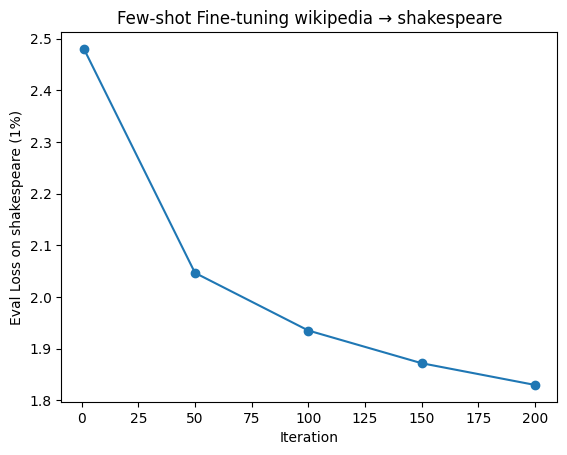

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from pathlib import Path
import random
import matplotlib.pyplot as plt
from tqdm import trange

# -------------------------
# Few-shot training & evaluation
# -------------------------
def few_shot_finetune(A, B, GPT, config, block_size=64, max_iters=200, batch_size=32, eval_interval=50):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1. Load pretrained checkpoint (dataset A)
    ckpt_path = f"drive/MyDrive/checkpoints/{A}/iter_4000.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")

    # 2. Build model with A’s vocab size
    config.vocab_size = len(ckpt["stoi"])
    model = GPT(config).to(device)
    model.load_state_dict(ckpt["model_state"])
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    # 3. Load dataset B, reusing A’s vocab
    text_B = Path(f"data/{B}.txt").read_text(encoding="utf-8", errors="ignore")
    dataset_B = CharDataset(text_B, block_size=block_size, stoi=ckpt["stoi"], itos=ckpt["itos"])
    loader_B = DataLoader(dataset_B, batch_size=batch_size, shuffle=True)

    # Subset (1%) for evaluation
    subset_size = max(1, len(dataset_B) // 100)
    subset_indices = random.sample(range(len(dataset_B)), subset_size)
    eval_subset = Subset(dataset_B, subset_indices)
    eval_loader = DataLoader(eval_subset, batch_size=batch_size)

    eval_losses, eval_steps = [], []

    # 4. Fine-tuning loop
    for step, (x, y) in zip(trange(max_iters), loader_B):
        x, y = x.to(device), y.to(device)
        logits, loss = model(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # Evaluate
        if (step + 1) % eval_interval == 0 or step == 0:
            model.eval()
            total_loss, count = 0, 0
            with torch.no_grad():
                for xb, yb in eval_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    _, l = model(xb, yb)
                    total_loss += l.item() * xb.size(0)
                    count += xb.size(0)
            avg_loss = total_loss / count
            eval_losses.append(avg_loss)
            eval_steps.append(step + 1)
            print(f"Step {step+1}: eval loss = {avg_loss:.4f}")
            model.train()

            # Save checkpoint
            save_path = f"drive/MyDrive/checkpoints/{A}_{B}_half/{A}_start0_{B}_run{step+1}.pt"
            torch.save({
                "model_state": model.state_dict(),
                "stoi": ckpt["stoi"],
                "itos": ckpt["itos"],
                "losses": eval_losses
            }, save_path)

            # Generate sample
            prompt = "The theorem states"
            encoded = torch.tensor([ckpt["stoi"].get(c, 0) for c in prompt], dtype=torch.long).unsqueeze(0).to(device)
            out = model.generate(encoded, max_new_tokens=100, temperature=0.8)[0].tolist()
            sample = "".join([ckpt["itos"].get(i, "?") for i in out])
            print(f"Sample @ step {step+1}:\n{sample}\n")

    # 5. Plot curve
    plt.plot(eval_steps, eval_losses, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel(f"Eval Loss on {B} (1%)")
    plt.title(f"Few-shot Fine-tuning {A} → {B}")
    plt.show()

    return eval_steps, eval_losses

# Example: fine-tune from Wikipedia → Math
steps, losses = few_shot_finetune("wikipedia", "shakespeare", GPT, config)


### **Deliverables**

* **Tables**: Zero-shot loss values (3×3).
* **Plots**: Few-shot loss curves (per experiment).
* **Samples**: Generated text at selected iterations.
* **Discussion**: Briefly how to structure their zero-shot results?


## **Part 3 – Inspecting the Softmax Output Layer**

In this part, you will explore how the model’s **output probabilities** evolve during training for different prompts.

### **What to Do**

* Choose **several prompts** (at least 2–3) that differ in domain and style (e.g., math expressions, natural language, biology terms).
* For each prompt, extract at each checkpoint:

  * The **softmax probability distribution** over the vocabulary.
  * The **entropy** of the distribution (a measure of model confidence/uncertainty).
* Plot the **trajectories of top candidate tokens** over checkpoints for each prompt.

### **What to Look For**

* **Predictability & Hardening**

  * Does the distribution concentrate (one token dominates) as training progresses?
  * Are some prompts much more predictable than others?

* **Entropy & Uncertainty**

  * Compare entropy across prompts.
  * Do in-domain prompts (e.g., math-related text) produce sharper, lower-entropy distributions?
  * Do out-of-domain prompts produce flatter, high-entropy distributions?

* **Biases in Token Predictions**

  * Are certain tokens consistently high-probability regardless of prompt?
  * Do different prompts encourage different sets of top tokens?

### **What to Report**

* Provide **plots** for each prompt.
* Give a **written description** of what you observe:

  * Where do probabilities harden?
  * Where do they remain diffuse?
  * How does this match your expectations about the model’s training data?
* Discuss what your findings imply about the model’s **predictability and specialization**.


number of parameters: 0.43M


/tmp/ipython-input-923744745.py:72: UserWarning: Glyph 32291 (\N{CJK UNIFIED IDEOGRAPH-7E23}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32291 (\N{CJK UNIFIED IDEOGRAPH-7E23}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


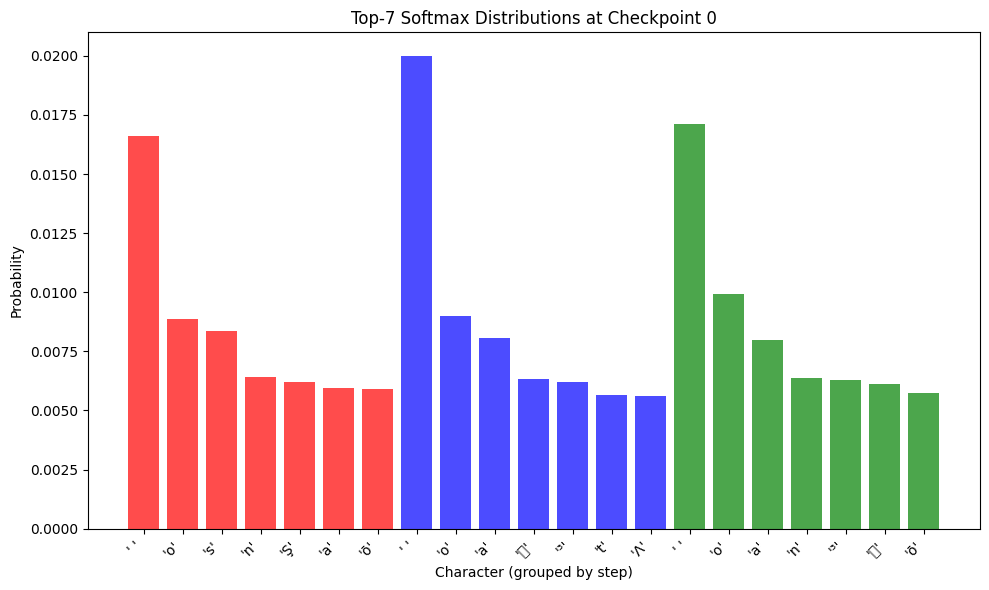

number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M


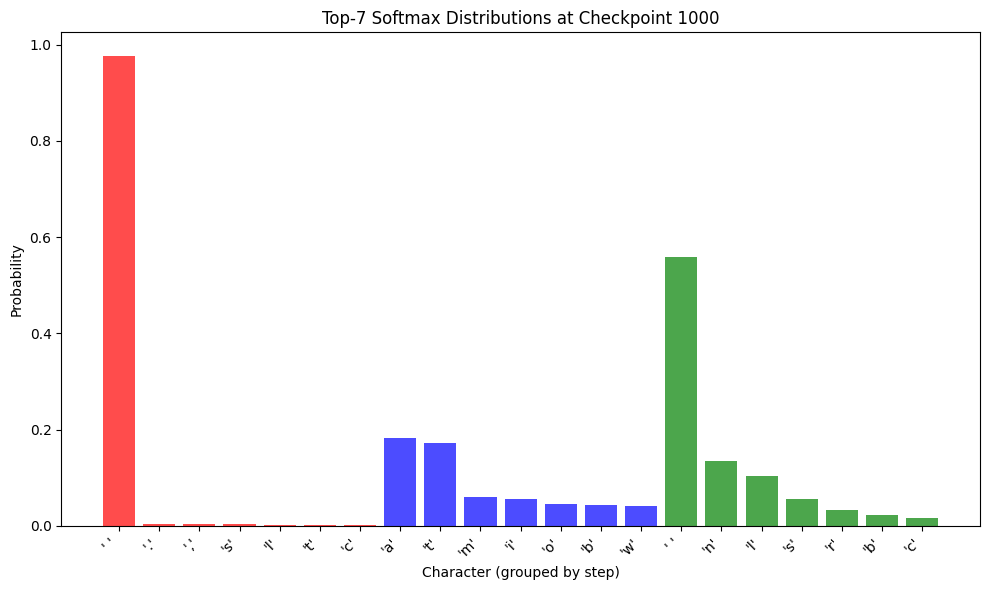

number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M


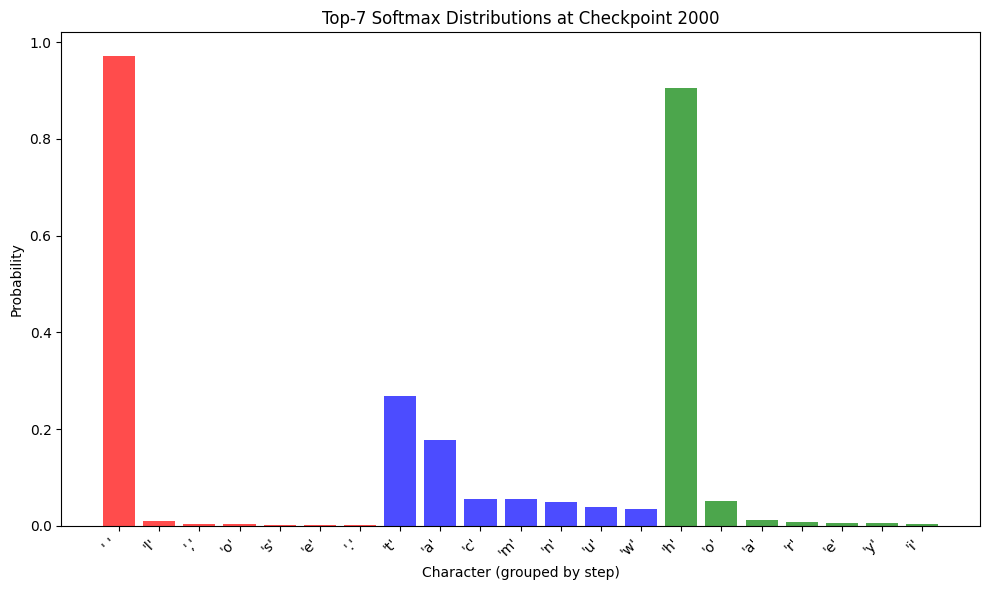

number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M


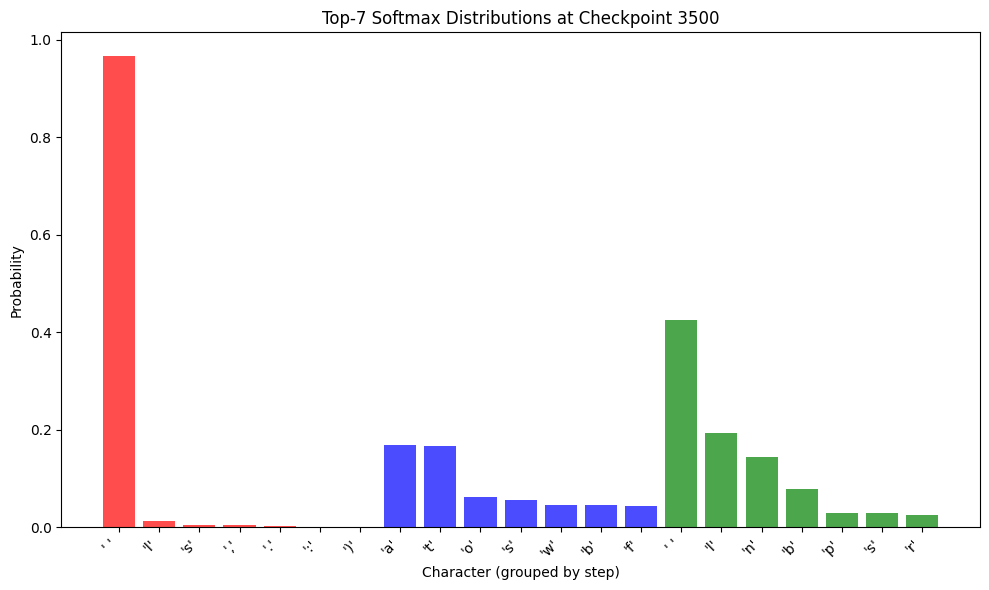

number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M


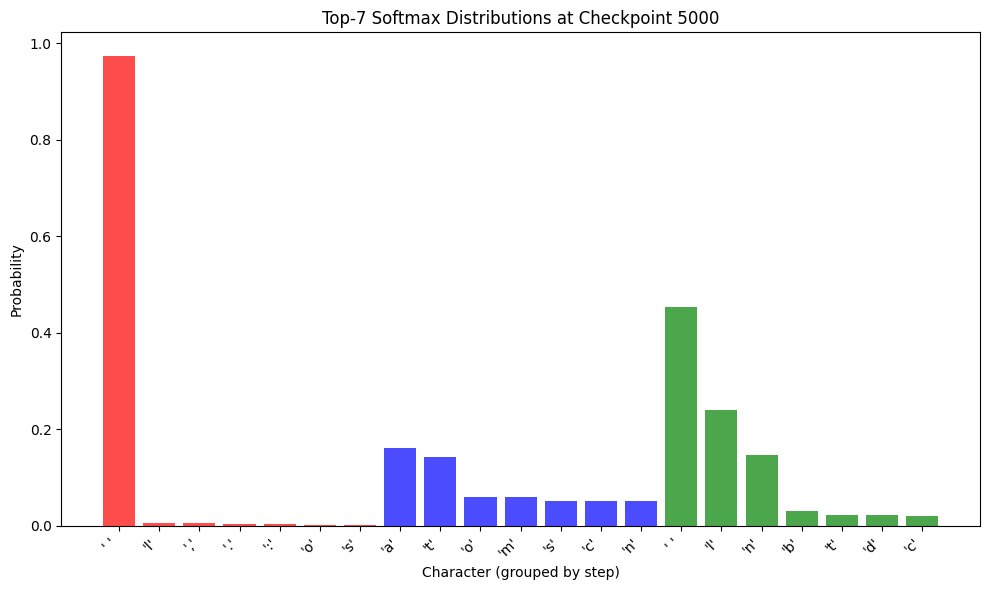

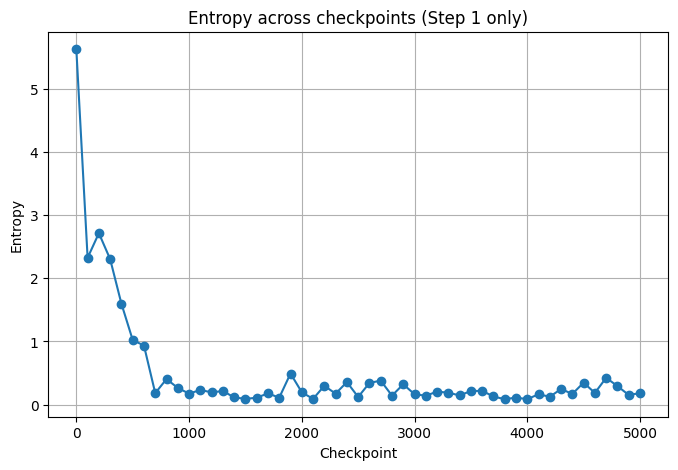

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ---------- CONFIG ----------
prompt = "The integral of x^2 is"
# prompt = "In biology, mitochondria are"
# prompt = "Once upon a time"

checkpoints_dir = "drive/MyDrive/checkpoints/wikipedia"
n_checkpoints = 51
chosen_idxs = ["0", "1000", "2000", "3500", "5000"]   # which checkpoints to visualize
steps = 3                           # how many autoregressive steps
topk = 7                            # how many top tokens to display

# ---------- HELPERS ----------
def encode(s, stoi):
    return torch.tensor([[stoi.get(ch, 0) for ch in s]], dtype=torch.long)

def get_multi_step_softmax(model, prompt_ids, steps):
    """
    Runs the model for multiple autoregressive steps, returns probability arrays per step.
    """
    all_probs = []
    input_ids = prompt_ids.clone()

    for _ in range(steps):
        with torch.no_grad():
            logits = model(input_ids)
            if isinstance(logits, tuple):
                logits = logits[0]

        # last-token logits
        last_logits = logits[:, -1, :].squeeze(0)
        probs = F.softmax(last_logits, dim=-1).cpu().numpy().flatten()
        all_probs.append(probs)

        # greedy decode
        next_token = torch.tensor([[np.argmax(probs)]])
        input_ids = torch.cat([input_ids, next_token], dim=1)

    return all_probs

def entropy_from_probs(probs):
    return -np.sum(probs * np.log(probs + 1e-12))

def plot_multi_step_softmax(probs_list, itos, ckpt_idx, steps=3, topk=7):
    plt.figure(figsize=(10,6))
    colors = ["red", "blue", "green"]

    all_chars = []
    all_probs = []
    all_colors = []

    for step, probs in enumerate(probs_list):
        top_idx = np.argsort(probs)[-topk:][::-1]
        top_probs = probs[top_idx]
        top_chars = [repr(itos[i]) for i in top_idx]

        all_chars.extend([f"{c}" for c in top_chars])
        all_probs.extend(top_probs)
        all_colors.extend([colors[step % len(colors)]] * len(top_chars))

    x = np.arange(len(all_chars))
    plt.bar(x, all_probs, color=all_colors, alpha=0.7)
    plt.xticks(x, all_chars, rotation=45, ha="right")

    plt.title(f"Top-{topk} Softmax Distributions at Checkpoint {ckpt_idx}")
    plt.ylabel("Probability")
    plt.xlabel("Character (grouped by step)")
    plt.tight_layout()
    plt.show()



# ---------- MAIN ----------
all_entropies = []
stoi, itos = None, None

for ckpt_idx in range(0,5001,100):
    ckpt_path = f"{checkpoints_dir}/iter_{ckpt_idx}.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")

    # Restore vocab
    if stoi is None:
        stoi, itos = ckpt["stoi"], ckpt["itos"]

    # Build model with correct vocab size
    vocab_size = len(stoi)
    config = GPTConfig(vocab_size=vocab_size,block_size=64)
    model = GPT(config)
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    # Encode prompt
    prompt_ids = encode(prompt, stoi)

    # Multi-step softmax distributions
    probs_list = get_multi_step_softmax(model, prompt_ids, steps=steps)

    # Record entropy of first-step distribution
    all_entropies.append(entropy_from_probs(probs_list[0]))

    # Plot selected checkpoints
    if str(ckpt_idx) in chosen_idxs:
        plot_multi_step_softmax(probs_list, itos, ckpt_idx, steps=steps, topk=topk)

# ---------- ENTROPY PLOT ----------
plt.figure(figsize=(8,5))
plt.plot(range(0,5001,100), all_entropies, marker="o")
plt.title("Entropy across checkpoints (Step 1 only)")
plt.xlabel("Checkpoint")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()


number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters

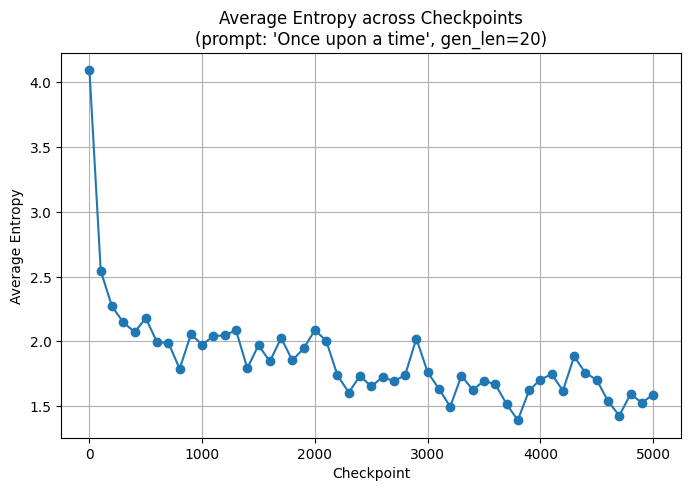

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ---------- CONFIG ----------
# prompt = "The integral of x^2 is"
# prompt = "In biology, mitochondria are"
prompt = "Once upon a time"
checkpoints_dir = "drive/MyDrive/checkpoints/shakespeare"
n_checkpoints = 51
gen_len = 20   # how many characters to generate

# ---------- HELPERS ----------
def encode(s, stoi):
    return torch.tensor([[stoi.get(ch, 0) for ch in s]], dtype=torch.long)

def compute_avg_entropy(model, prompt_ids, gen_len):
    """
    Generate gen_len characters and compute average entropy over steps.
    """
    input_ids = prompt_ids.clone()
    entropies = []

    for _ in range(gen_len):
        with torch.no_grad():
            logits = model(input_ids)
            if isinstance(logits, tuple):
                logits = logits[0]

        last_logits = logits[:, -1, :].squeeze(0)
        probs = F.softmax(last_logits, dim=-1).cpu().numpy().flatten()
        entropy = -np.sum(probs * np.log(probs + 1e-12))
        entropies.append(entropy)

        # greedy decode: feed back argmax
        next_token = torch.tensor([[np.argmax(probs)]])
        input_ids = torch.cat([input_ids, next_token], dim=1)

    return np.mean(entropies)

# ---------- MAIN ----------
stoi, itos = None, None
avg_entropies = []

for ckpt_idx in range(0,5001,100):
    ckpt_path = f"{checkpoints_dir}/iter_{ckpt_idx}.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")

    # Restore vocab
    if stoi is None:
        stoi, itos = ckpt["stoi"], ckpt["itos"]

    # Build model
    vocab_size = len(stoi)
    config = GPTConfig(vocab_size=vocab_size,block_size=64)
    model = GPT(config)
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    # Encode prompt
    prompt_ids = encode(prompt, stoi)

    # Compute average entropy for 100 generated characters
    avg_entropy = compute_avg_entropy(model, prompt_ids, gen_len)
    avg_entropies.append(avg_entropy)

# ---------- PLOT ----------
plt.figure(figsize=(8,5))
plt.plot(range(0,5001,100), avg_entropies, marker="o")
plt.title(f"Average Entropy across Checkpoints\n(prompt: {prompt!r}, gen_len={gen_len})")
plt.xlabel("Checkpoint")
plt.ylabel("Average Entropy")
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def load_model(ckpt_path,  GPT):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    config = type("GPTConfig", (), ckpt["config"])
    stoi, itos = ckpt["stoi"], ckpt["itos"]
    config.vocab_size = len(stoi)
    model = GPT(config)
    model.load_state_dict(ckpt["model_state"])
    return model, stoi, itos

def inspect_softmax(model, prompt, stoi, itos, top_k=10):
    # pick a fallback index if <unk> not in vocab
    unk_idx = stoi.get("<unk>", next(iter(stoi.values())))

    x = torch.tensor([[stoi.get(c, unk_idx) for c in prompt]], dtype=torch.long)
    with torch.no_grad():
        probs = F.softmax(model(x)[0][:, -1, :], dim=-1).squeeze()
    entropy = -(probs * torch.log(probs + 1e-12)).sum().item()
    top_p, top_i = torch.topk(probs, top_k)
    return {
        "prompt": prompt,
        "entropy": entropy,
        "probs": [(itos[i.item()], p.item()) for i, p in zip(top_i, top_p)]
    }



## **Part 4 – Grad-CAM for Language Models**

In this part, you’ll build a lightweight version of *Grad-CAM* for a language model. Instead of visualizing gradients in images, we’ll look at how gradients flow into **token embeddings** to measure which input tokens most affect a model’s probability of generating a target token.

### **Steps**

1. **Compute gradients**

   * Use the provided `token_gradients` function.
   * This function backpropagates from the probability of a **target token** (e.g., `"e"`) back to the input embeddings.
   * For each input token, it returns the gradient norm, which indicates **how much changing that token would affect the prediction**.

2. **Experiment with checkpoints**

   * Run the method across checkpoints of your trained model (e.g., every 100 iterations).
   * Track how gradient importance changes over time.
   * Try different prompts and different target tokens.

3. **Compare across models**

   * Run the same analysis on domain-trained models (e.g., trained on Wikipedia vs. math text).
   * Compare: Do the same tokens consistently drive predictions? Or do models in different domains “care” about different tokens?


### **Discussion Questions**

1. **Character influence:**
   Which characters consistently receive the highest gradient norms? Are they vowels, consonants, punctuation, or digits? Do frequent letters (like “e”) dominate, or do rare characters sometimes matter more?
2. **Checkpoint dynamics:**
   How does the distribution of influential tokens change as training progresses? Does the model become more focused or more diffuse?
3. **Domain differences:**
   Compare results from different domain-trained models. Do Wikipedia-trained models rely more on content words, while math-trained ones emphasize structure/symbols?
4. **Zero-shot vs few-shot:**
   If you add example completions to the prompt (few-shot), how does the gradient map shift compared to zero-shot?
5. **Interpretability limits:**
   What are the limitations of gradient-based methods? Do high gradient norms always mean high “importance”? When might this method be misleading?
  


number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M


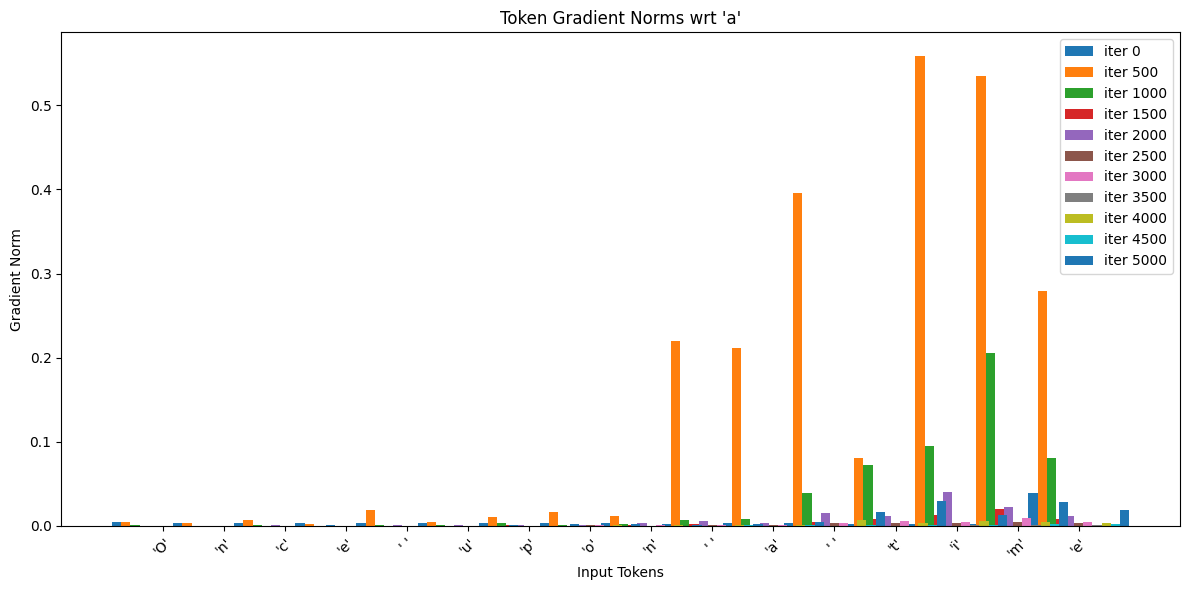

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def token_gradients(model, prompt, target_token, stoi, itos):
    """
    Compute gradient norms per input token wrt probability of `target_token`.
    """
    model.eval()
    x = torch.tensor([stoi[c] for c in prompt], dtype=torch.long)[None, :]

    grads = {}

    def save_grad(module, inp, out):
        out.retain_grad()
        grads['emb'] = out

    handle = model.transformer.wte.register_forward_hook(save_grad)

    # Forward pass
    logits, _ = model(x)
    last_logits = logits[:, -1, :]   # [B, vocab]

    target_idx = stoi.get(target_token, None)
    if target_idx is None:
        raise ValueError(f"Token {target_token!r} not in vocab")

    probs = F.softmax(last_logits, dim=-1)
    target_prob = probs[0, target_idx]

    # Backprop
    model.zero_grad(set_to_none=True)
    target_prob.backward()

    grad_norms = grads['emb'].grad[0].norm(dim=-1)  # [T]
    tokens = [repr(itos[i.item()]) for i in x[0]]   # use repr here!

    handle.remove()
    return list(zip(tokens, grad_norms.tolist()))

# ---------- Example Loop over checkpoints ----------
checkpoints_dir = "drive/MyDrive/checkpoints/shakespeare"
# prompt = "The integral of x^2 is"
# prompt = "In biology, mitochondria are"
prompt = "Once upon a time"
# target_token = "x"
# target_token = "p"
target_token = "a"

grad_history = []

for ckpt_idx in range(0, 5001, 500):  # every 100th checkpoint
    ckpt = torch.load(f"{checkpoints_dir}/iter_{ckpt_idx}.pt", map_location="cpu")

    stoi, itos = ckpt["stoi"], ckpt["itos"]
    vocab_size = len(stoi)

    config = GPTConfig(vocab_size=vocab_size, block_size=64)
    model = GPT(config)
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    grads = token_gradients(model, prompt, target_token, stoi, itos)
    grad_history.append((ckpt_idx, grads))

# ---------- Visualization ----------
n_checkpoints = len(grad_history)
bar_width = 0.15  # width of each checkpoint bar

tokens = [tok for tok, _ in grad_history[0][1]]
x = np.arange(len(tokens))

plt.figure(figsize=(12, 6))
for i, (ckpt_idx, grads) in enumerate(grad_history):
    _, values = zip(*grads)
    plt.bar(x + i*bar_width, values, width=bar_width, label=f"iter {ckpt_idx}")

plt.xticks(x + (n_checkpoints-1)*bar_width/2, tokens, rotation=45)
plt.title(f"Token Gradient Norms wrt '{target_token}'")
plt.xlabel("Input Tokens")
plt.ylabel("Gradient Norm")
plt.legend()
plt.tight_layout()
plt.show()
